# $L^2$ Orthogonal Projection

Given a domain $X\subseteq \mathbb{R}^d$ and a probability measure $d\rho$ over $X$, we are interested in approximating an unknown function $u \in L^2(X, d\rho)$ by its orthogonal projection onto an $m$-dimensional subspace $V_m$ of $L^2(X, d\rho)$. That is, we approximate $u$ by

$$\underset{v \in V_m}{\arg\min} || u - v||_{L^2}.$$

In practice, we cannot evaluate the term $||u - v||_{L^2}$ since we do not know $u$. Instead, suppose we have observations $y^i = u(x^i)$ at points $x^i\in X$, $i=0,\dots, n-1$. We can approximate the $L^2$ norm above by the (semi)-norm 

$$ || u ||_n := \bigg(\frac{1}{n}\sum_{i=0}^{n -1} w^i|u(x^i)|^2\bigg)^{1/2}, $$
defined for a sequence of weights $\{w^i\}_{i=0,\dots,n-1}$. Thus, we approximate the orthogonal projection of $u$ onto $V_m$ by the least-squares minimiser 

$$\hat u := \underset{v\in V_m}{\arg \min} ||u - v||_n. $$

Given a (orthonormal) basis $L_0,\dots, L_{m-1}$ of $V_m$ we can express any $v \in V_m$ as $\sum_{j=0}^{m-1}v_jL_j$, where $\textbf{v} = (v_0,\dots,v_{m-1})^T\in \mathbb{R}^m$. Hence, we seek the coefficient vector $\textbf{v}$ minimising $|| u - v||_n$. Differentiating 

\begin{align}
\frac{\partial}{\partial v_k}||u - v||_n &=\frac{\partial}{\partial v_k}\bigg(\frac{1}{n}\sum_{i=0}^{n-1} w^i\bigg|u(x^i) - \sum_{j=0}^{m-1}v_jL_j(x^i)\bigg|^2\bigg)^{1/2} \\
&= -\frac{\sum_{i=0}^{n-1}L_k(x^i)w^i\big(u(x^i) - \sum_{j=0}^{m-1}v_jL_j(x^i)\big)}{n||u - v||_n},
\end{align}
and so $||u - v||_n$ is minimised when 

\begin{align}
\sum_{i=0}^{n-1}w^iL_k(x^i)u(x^i) &= \sum_{j=0}^{m-1}v_j\sum_{i=0}^{n-1}L_j(x^i)L_k(x^i) \\
\implies \langle L_k, u \rangle_n &= \sum_{j=0}^{m-1} v_j\langle L_k, L_j\rangle_n,
\end{align}
where $\langle \cdot,\cdot\rangle_n$ is the inner product corresponding to $||\cdot||_n$. Hence, the vector of coefficients $\textbf{v}$ defining $\hat u$ is given by 

$$G \textbf{v} = d, $$

where $G_{kj} = \langle L_k, L_j\rangle_n$ and $d_k = \langle L_k, u\rangle_n$ for $j, k = 0 \dots m-1$. The above problem has a unique solution when $G$ is nonsingular (if and only if $||\cdot||_n$ is a proper norm on $V_m$). Otherwise, there will be infinitely many solutions, and we choose the minimal Euclidean norm solution to the above system.


We consider the case where $w^i = 1$ and the points $x^i$ are randomly drawn according to $d\rho$. In this case $n^{-1}\sum_{i=0}^{n-1}|u(x^i)|^2$ is a Monte-Carlo approximation of $\int_X |u(x)|^2d\rho$ and $||u||_n \to ||u||$ as $n\to \infty$.

This method is implemented in the code cell below (where we allow arbitrary weights to be chosen).

In [1]:
# Use L2 orthogonal projection to fit a function through training data (x,y).
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Define norm || v ||_n = (0.5 sum wi*|v(xi)|^2)^0.5 and corresponding inner
# product
# Compute the inner product of functions v, w with values v(xi) = ai and 
# w(xi) = bi, ip_n_vec allows b to be a matrix, computes inner product of v 
# with functions defining each row of b. 
ip_n_vec = lambda a, b, w:  np.sum((w*a)*b, axis = 1)/a.size  # Vector output
ip_n = lambda a, b, w:  np.sum((w*a)*b)/a.size   # Scalar output
norm_n = lambda a, w: np.sqrt(ip_n(a, a, w))

# Define function for L2 projection
def L2_proj(y, w, L):
    """
    y <- n-dimensional vector of observations.
    w <- vector of weights
    L <- m x n matrix with rows L[i,j] = L_i(x_j), containing basis function L_i evaluated at the point x_j 
         corresponding to observation y[j] j=0,..,n-1
    """
    m = L.shape[0]  # No. basis functions
    
    # Generate matrix G and vector d:
    G = np.zeros((m,m))
    d = np.zeros(m)
    for i in range(m):
        G[i,:] = ip_n_vec(L[i,:], L, w)
        d[i] = ip_n(L[i,:], y, w)
    
    C = np.linalg.cond(G)
    
    if C < 10**16:  # If problem is non-singular
        return (np.linalg.solve(G, d), 'G is non-singular', C)
    
    else: # If problem is singular (compute ridge regularised solution)
        return (np.linalg.solve(G.transpose()@G + 2*np.eye(m),G.transpose()@d), 'G is singular', C)

### Univariate Case
As a choice of basis function for the space $V_m$ we choose the (normalized) Chebyshev polynomials $L_j$ defined in 1 variable via the identity
\begin{align}
L_0(x) &= 1 \\
L_j(x) &= \sqrt{2}\cos(j\arccos (x)), \quad j\geq 1.
\end{align}

For $X = [-1,1]$, Chebyshev polynomials are orthonormal in $L^2(X,d\rho)$ under the measure 
$$d\rho = \frac{1}{\pi\sqrt{1 - x^2}}dx. $$

$L^2$ random projection is used to approximate the function $\sin 2\pi x$ defined on $[-1,1]$ below for $m=10$, where the points $x^i$ are sampled according to the Chebyshev measure using the following procedure (Inversion Transform Sampling):
- The Chebyshev measure has c.d.f. $$\Phi(x) = \frac{\arcsin x}{\pi} + \frac{1}{2},$$ on $[-1,1]$.
- For $u\sim\text{Uniform}(0,1)$ the random variable $\Phi^{-1}(u) = -\cos(\pi u)$ is distributed according to the Chebyshev measure.


As described in [1, Theorem 1], we choose the number $n$ of training points to satisfy $n/\log n > 2m$ (In the setup there, $K_m \leq 2m$ for the Chebyshev polynomials, where the factor $2$ comes from the normalization constant $\sqrt{2}$) to achieve the desired convergence properties.

20.34593135710914


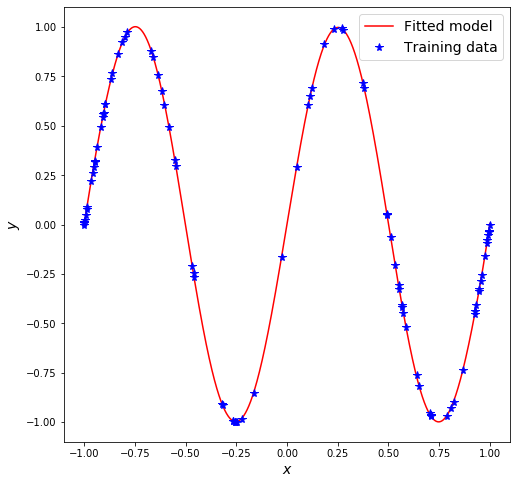

In [2]:
# Create function to sample from Chebyshev measure dp = (1-x^2)^(-1/2)/pi *dx on [-1, 1] using ITS Since the 
# Chebyshev measure has c.d.f arcsin(x)/pi + 1/2, we sample values from its inverse -cos(pi*u) where 
# u ~ Uniform[0,1].
Chebyshev_sample = lambda shape: -np.cos(np.pi*np.random.uniform(0,1,shape))
np.random.seed(1) # Fix seed

# Chebyshev Polynomials
def Chebyshev_poly(m, x):
    """
    m <- integer, x <- vector
    Returns m x |x| matrix with i,j'th entry L_i(x_j) where L_i is the i'th Chebyshev polynomial for i=0,..,m-1
    """
    L = np.ones((m, x.size))
    for i in np.arange(1,m):
        L[i,:] = np.sqrt(2)*np.cos(i*np.arccos(x))
    return(L)
    
# Define parameters
m = 10
n = int(4*m*np.log(m))
print(n/np.log(n))
# Create training data and uniform weights
x = Chebyshev_sample(n)
y = np.sin(2*np.pi*x)
w = np.ones(n)

# Fit model
(fit1, s1, C1) = L2_proj(y, w, Chebyshev_poly(m, x))


test_x = np.linspace(-1,1,10000)
test_y = np.sum(fit1.reshape((m,1))*Chebyshev_poly(m, test_x), axis = 0)

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize = (8,8), sharex = True)
ax.plot(test_x, test_y, 'r-', label = 'Fitted model')
ax.plot(x, y, 'b*', label = 'Training data', ms = 8)
ax.set_xlabel(r'$x$', fontsize = 14)
ax.set_ylabel(r'$y$', fontsize = 14)
ax.legend(loc = 'upper right', fontsize = 14)

### Multivariate Setting
We consider the case $d = 2$, again using a basis generated by Chebyshev polynomials. Letting $L_i$ denote the $i$'th Chebyshev polynomial, we take a basis to be given by the polynomials $L_i(x)L_j(x)$ where $i,j \in \{0, \dots, \hat m-1\}$ giving a space $V_m$ of dimension $\hat m^2$. The training points $x^i$ are sampled according to the Chebyshev measure in each spatial dimension, and we approximate the function $u(x_1, x_2) = \sin x_1 + \cos x_2$.

195.9914015520553


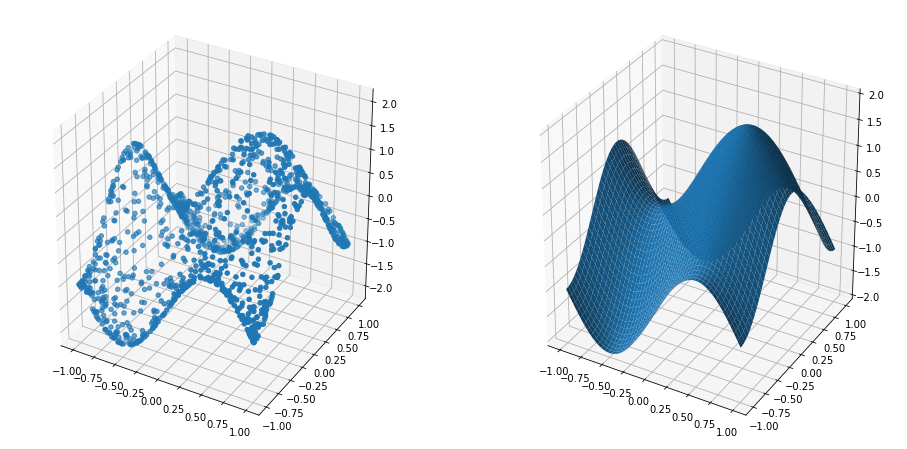

In [3]:
# Multivariate Setting
# Define function to give basis of Chebyshev functions in d-dimensions
def Chebyshev_basis(index, data):
    """
    index <- d-dimensional vector of # Basis functions in each dimension
    data <- d x n matrix with columns representing individual data points
    Returns Product(d_i)_i x n matrix with i,j'th entry L_i(x[:,j]) where L_i is the i'th basis function given by
    T_i0(x[0,k])T_i1(x[1,k])....T_id(x[d,k]) where T_in are the Chebyshev polynomials and we use all possibilities 
    0 <= in <= index_n - 1
    """
    if index.size == 1:  # If the data is one-dimensional, use the function above
        return Chebyshev_poly(index[0], data)
    
    else:
        L = np.zeros((np.prod(index), data.shape[1]))  
        T0 = Chebyshev_poly(index[0], data[0,:])  # Compute basis functions along dimension 0
        Tremaining = Chebyshev_basis(index[1:], data[1:,:])  # Recursively compute basis along dimensions 1,..
        d = Tremaining.shape[0]
        for i in range(index[0]):
            L[i*d:(i+1)*d,:] = T0[i,:]*Tremaining
    return L



# Test code in multidimensional case y = sin(pi(x_1 + x_2))
index = np.array([9,9])
m = np.prod(index)
n = int(4*m*np.log(m))
w = np.ones(n)
data = Chebyshev_sample((2, n))
y = np.sin(np.pi*data[0,:]) + np.cos(np.pi*data[1,:])
print(n/np.log(n))

L = Chebyshev_basis(index, data)
(fit2, s2, C2) = L2_proj(y, w, L)

x_1, x_2 = np.meshgrid(np.linspace(-1,1,500), np.linspace(-1,1,500))
test_y2 = np.sum(fit2.reshape(m,1)*Chebyshev_basis(index, np.array([x_1.flatten(), x_2.flatten()])),\
                 axis = 0).reshape((500,500)) 


fig2 = plt.figure(figsize = (16,8))
ax2 = fig2.add_subplot(121, projection = '3d')
ax3 = fig2.add_subplot(122, projection = '3d')
Axes3D.plot_surface(ax3, x_1, x_2, test_y2)
Axes3D.scatter(ax2, data[0,:], data[1,:], np.sin(np.pi*data[0,:]) + np.cos(np.pi*data[1,:]))

### Next steps:
I aim to add to this code in the following ways:
- Generate a more efficient way to create a basis in $d$-dimensions. Currently, with $\hat m$ basis polynomials in each dimension we have $m = \hat m ^d$ basis polynomials, which suffers from the curse of dimensionality.
- Perform error analysis for univariate case.

## References
[1] Cohen, A. & Migliorati, G., 2016. Optimal weighted least-squares methods.